In [189]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import tensorboard
from torch.utils.tensorboard import SummaryWriter

This is an attempt to build a RNN/LSTM model to predict stock prices

# Load data

In [170]:
data = pd.read_csv('MSFT.csv')
n_samples = len(data)
n_test_samples = int(n_samples/5)
n_train_samples = n_samples - n_test_samples
input_data = data.iloc[:,1:7].to_numpy()

print('number of samples:', n_samples)
data.Date = pd.to_datetime(data.Date)
data.head()

number of samples: 9187


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


## plot the stock prices

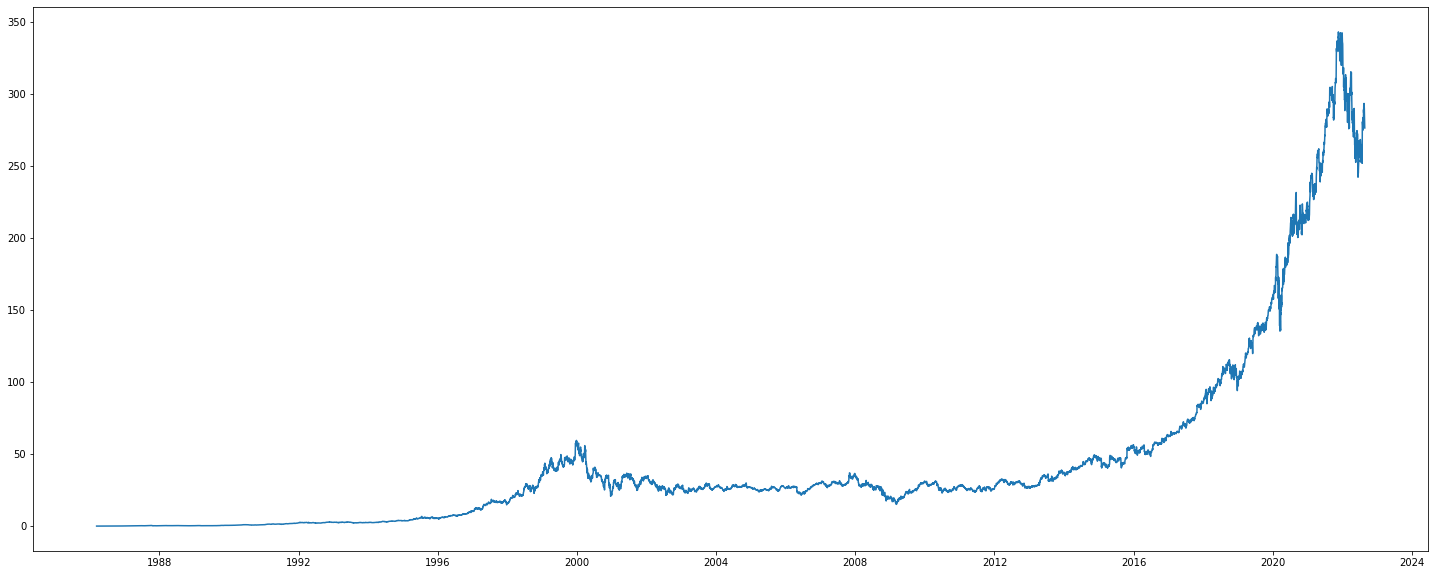

In [171]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(data.Date ,data.Close)

# Create Data transformer

In [172]:
class DataTransformer():
    def __init__(self,data):
        self.data_min = data.min(axis=0)
        self.data_max = data.max(axis=0)

    def __call__(self, data):
        return  (data - self.data_min) / (self.data_max - self.data_min)

data_transformer = DataTransformer(input_data)


## build datasets

In [173]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, filename: str, ws: int = 10, i_start: int = 0, i_end: int = None, transformer=None):
        """
        Initializes the data
        @param filename: Name of the csv file
        @param ws: window size
        @param i_start: index of the first data row
        @param i_end: index of the last data row
        """
        self.transformer = transformer
        np_array = pd.read_csv(filename).to_numpy()[i_start:i_end,1:7]
        if transformer :
            np_array = transformer(np_array)
        file_data = torch.from_numpy(np_array.astype(float))
        x = []
        labels = []
        for i in range(len(file_data)-ws):
            x.append(file_data[i:i+ws])
            labels.append(file_data[i+ws])
        self.data = torch.stack(x).type(torch.FloatTensor)
        self.labels = torch.stack(labels).type(torch.FloatTensor)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item], self.labels[item]



In [174]:
window_size = 15
batch_size = 64

train_dataset = Dataset('MSFT.csv',window_size,i_end=n_train_samples,transformer=data_transformer)
test_dataset = Dataset('MSFT.csv',window_size,i_start=n_train_samples,transformer=data_transformer)



# Define the model

In [175]:
class Model(nn.Module):
    def __init__(self,input_size=6,hidden_size=50,out_size=1,num_layers=1,batch_first=True):
        super(Model,self).__init__()
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers,batch_first=batch_first)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = self.init_hidden(1)

    def init_hidden(self,batch_size=1):
        self.hidden = (torch.zeros((self.num_layers,batch_size,self.hidden_size)),torch.zeros((self.num_layers,batch_size,self.hidden_size)))

    def forward(self,x):
        out, self.hidden = self.rnn(x,self.hidden)
        pred = self.linear(out)
        return pred[:,-1]


# Initialize model

In [176]:
model = Model(num_layers=1)
model.init_hidden(batch_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
print(model)

Model(
  (rnn): LSTM(6, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


# Train the model

In [194]:
test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)

In [195]:
start = time.time()
epochs = 50
writer = SummaryWriter()
j = 0
loss_sum = 0
for i in range(epochs):
    for train_x, train_y in train_data_loader:
        if len(train_x) != batch_size:
            continue
        input_seq = train_x.reshape(batch_size,window_size,-1)
        model.init_hidden(batch_size=batch_size)
        optimizer.zero_grad()
        y_pred = model(input_seq)
        loss = criterion(y_pred,train_y[:,3].reshape(batch_size,-1))
        loss_sum += loss.item()
        j+=1
        loss.backward()
        optimizer.step()

    if i%(int(epochs/5)) == 0:
        writer.add_scalar('Loss',loss_sum/(epochs/5),j)
        end = time.time()
        print('Epoch: %d  Loss: %f  Elapsed time: %f'%(i,loss,end-start))
        loss_sum = 0

end = time.time()
print('finished in %f s' % (end-start))
writer.flush()
writer.close()


Epoch: 0  Loss: 0.000038  Elapsed time: 1.257965
Epoch: 10  Loss: 0.000037  Elapsed time: 11.840082
Epoch: 20  Loss: 0.000036  Elapsed time: 22.581338
Epoch: 30  Loss: 0.000034  Elapsed time: 33.318011
Epoch: 40  Loss: 0.000033  Elapsed time: 44.159563
finished in 53.916454 s


In [193]:
%load_ext tensorboard
%tensorboard --logdir=runs

Launching TensorBoard...

# Test prediction

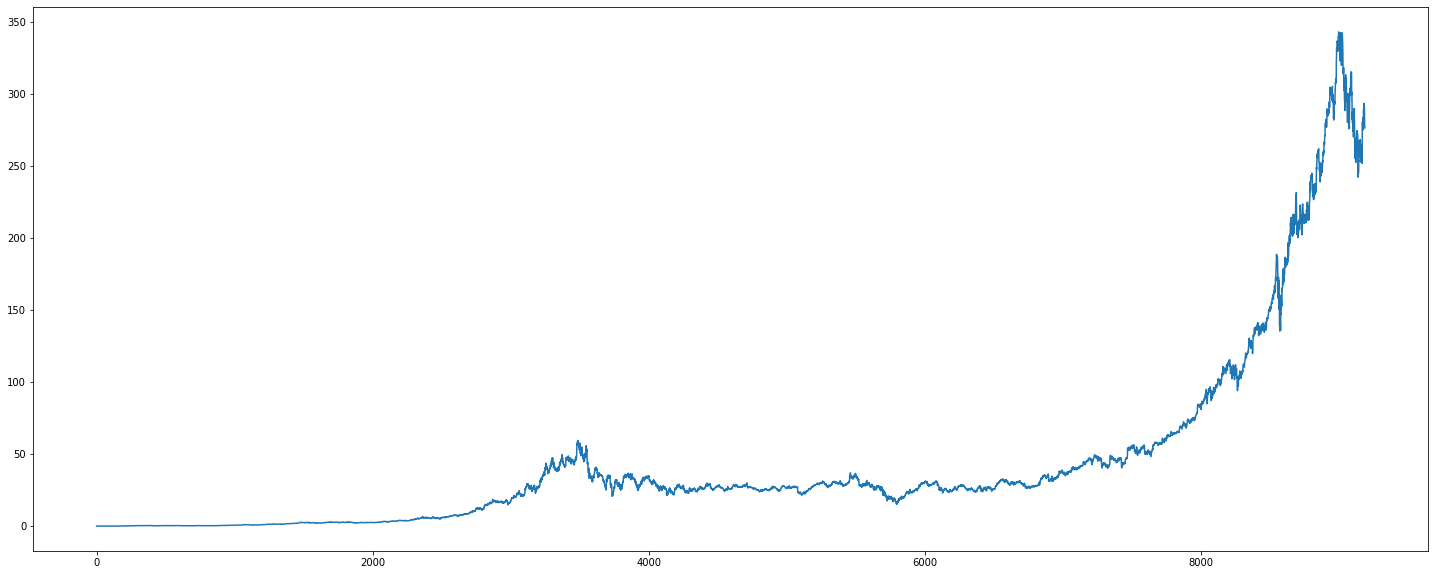

In [179]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(np.linspace(0,len(input_data),len(input_data)) ,input_data[:,3])

In [180]:
with torch.no_grad():
    model.init_hidden(len(test_dataset))
    y_pred = model(test_dataset[:][0])

In [181]:
y_pred.shape

torch.Size([1822, 1])

In [182]:
y = test_dataset[:][1][:,3]

In [183]:
len(y)

1822

In [184]:
len(train_dataset)

7335

(1.0, 1550.0)

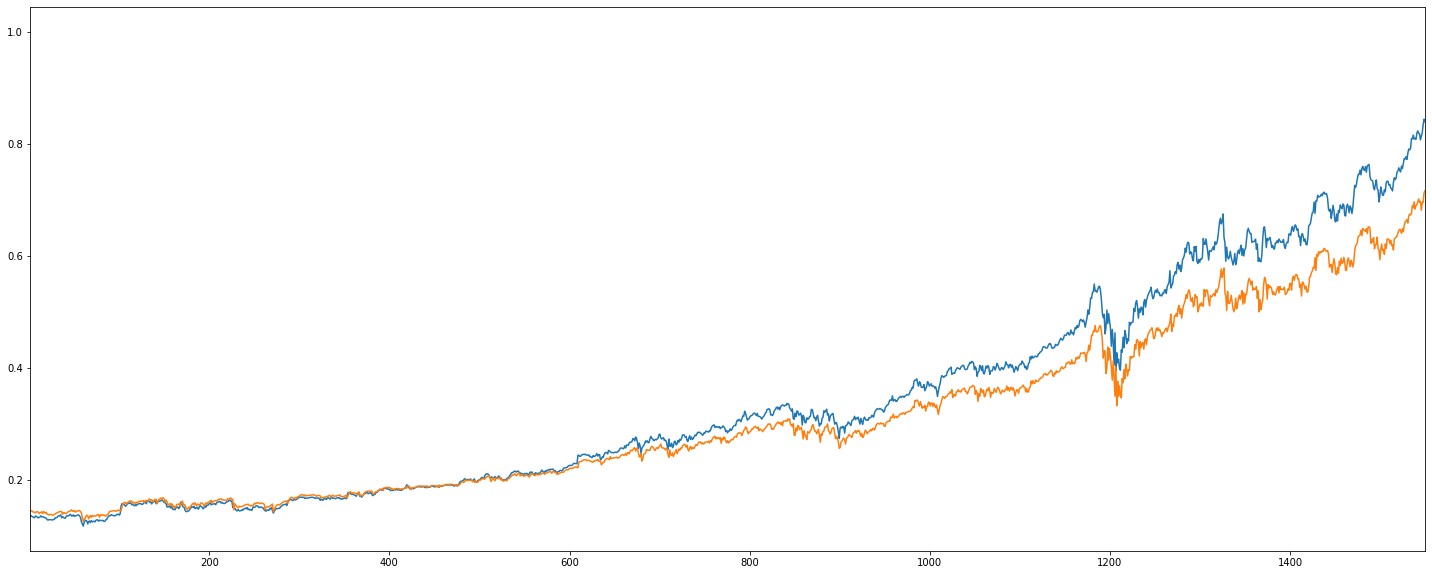

In [186]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(np.linspace(0,len(y),len(y)) ,y)
plt.plot(np.linspace(0,len(y),len(y)) ,y_pred.detach().numpy())
plt.xlim(1,1550)